Code for analyzing a trained dino model's embeddings. Student and teacher projections are compared using entropy and kl_divergence as metrics to gauge whether they are learning diverse representations, while still having the student approximate the teacher's predictions.

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
torch.manual_seed(0) # Set seed before importing other modules
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import sys
import os
from utils.get_data import AVMNISTDataModule
from models.dino import MultiModalDINO, MultiModalDINOLightning, CentralMultiModalEncoder, \
                        DualViTMultiModalEncoder
# torch.multiprocessing.set_start_method('spawn')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_path = os.getcwd()
dual_vit_name = 'multi_dual_vit_mlp_acc_13062025_072024'
central_name = 'multi_central_mlp_acc_13062025_102517'
best_dual_vit = 'epoch=85-step=36980.ckpt'
best_central = 'epoch=22-step=9890.ckpt'
best_model_path1 = os.path.join(current_path, 'experiments_results', 'step1', 'dino experiments', dual_vit_name, best_dual_vit)
best_model_path2 = os.path.join(current_path, 'experiments_results', 'step1', 'dino experiments', central_name, best_central)
sys.path.append(current_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Optional

def check_output_entropy(projections: torch.Tensor) -> float:
    """
    Calculate the entropy of projected outputs to detect potential collapse.
    
    Args:
        projections: Projected outputs from student/teacher [n_views, batch_size, proj_dim]
    
    Returns:
        Average entropy of the output distribution
    """
    # Flatten all views and batches together
    flat_proj = projections.view(-1, projections.size(-1))
    probs = F.softmax(flat_proj, dim=1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1).mean().item()
    print(f"Average Projection Entropy: {entropy:.4f} (max possible: {np.log(flat_proj.size(-1)):.4f})")
    return entropy

def measure_kl_divergence(student_projs: torch.Tensor, 
                         teacher_projs: torch.Tensor,
                         temp: float = 0.1) -> float:
    """
    Measure KL divergence between student and teacher projections.
    
    Args:
        student_projs: Student projections [n_views*bs, proj_dim]
        teacher_projs: Teacher projections [n_views*bs, proj_dim]
        temp: Temperature for sharpening
    
    Returns:
        KL divergence value
    """
    # Ensure we're comparing corresponding views
    # Student typically has more views (local + global) than teacher (global only)
    n_teacher_samples = teacher_projs.shape[0]
    student_projs = student_projs[-n_teacher_samples:]  # Take matching number of samples (only global ones at the end)
    
    # Normalize and apply temperature
    student = F.normalize(student_projs, p=2, dim=-1)
    teacher = F.normalize(teacher_projs, p=2, dim=-1)
    
    student_probs = F.log_softmax(student / temp, dim=-1)
    teacher_probs = F.softmax(teacher / temp, dim=-1)
    
    kl_div = F.kl_div(student_probs, teacher_probs, reduction='batchmean')
    print(f"KL Divergence (temp={temp}): {kl_div:.4f} (computed on {n_teacher_samples} samples)")
    return kl_div.item()

def plot_embeddings(embeddings: torch.Tensor, 
                   labels: Optional[torch.Tensor] = None, 
                   title: str = "Embedding Visualization"):
    """
    Visualize embeddings using t-SNE.
    
    Args:
        embeddings: Raw embeddings from encoder [n_views, bs, embed_dim]
        labels: Optional labels for coloring
        title: Plot title
    """
    # Use first view's embeddings only
    emb = embeddings[0].cpu().numpy() if embeddings.dim() == 3 else embeddings.cpu().numpy()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(emb)
    
    plt.figure(figsize=(10, 8))
    if labels is not None:
        labels = labels.cpu().numpy()
        plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar()
    else:
        plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
    
    plt.title(f"{title}\n(TSNE of {emb.shape[0]} samples)")
    plt.tight_layout()
    plt.show()

def check_ema_update(student: nn.Module, 
                    teacher: nn.Module) -> Tuple[float, Dict[str, float]]:
    """
    Check EMA update quality between student and teacher.
    
    Returns:
        Tuple of (average_diff, layerwise_diffs)
    """
    layer_diffs = {}
    total_diff, total_params = 0., 0
    
    for (s_name, s_param), (t_name, t_param) in zip(
        student.named_parameters(), teacher.named_parameters()):
        
        assert s_name == t_name, "Parameter name mismatch!"
        diff = torch.norm(t_param.data - s_param.data).item()
        rel_diff = diff / (torch.norm(s_param.data).item() + 1e-9)
        
        layer_diffs[s_name] = rel_diff
        total_diff += rel_diff
        total_params += 1
    
    avg_diff = total_diff / total_params
    print(f"EMA Update Quality:")
    print(f"- Average relative param difference: {avg_diff:.6f}")
    print(f"- Layerwise differences:")
    for name, diff in sorted(layer_diffs.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {name}: {diff:.4f}")
    
    return avg_diff, layer_diffs

def analyze_multimodal_dino(pretrained_dino: 'MultiModalDINO',
                            dataloader: torch.utils.data.DataLoader,
                            n_global_views: int = 2,
                            n_local_views: int = 4) -> Dict[str, torch.Tensor]:
    """
    Full analysis pipeline for MultiModalDINO models.
    """
    device = next(pretrained_dino.parameters()).device
    
    pretrained_dino.eval()
    results = {
        'embeddings': [],
        'student_global_projs': [],
        'student_local_projs': [],
        'teacher_projs': [],
        'labels': []
    }
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images, spectrograms, labels = batch[0], batch[1], batch[2]
            batch_size = images.shape[0]
            
            # Generate global and local views for both modalities
            global_image_views = torch.stack([images]*n_global_views, dim=1).float().to(device)
            local_image_views = torch.stack([images]*n_local_views, dim=1).float().to(device)
            global_audio_views = torch.stack([spectrograms]*n_global_views, dim=1).float().to(device)
            local_audio_views = torch.stack([spectrograms]*n_local_views, dim=1).float().to(device)
            
            labels = labels.to(device)
            
            # Forward pass through MultiModalDINO
            student_projs, teacher_projs, _ = pretrained_dino(
                (global_image_views, global_audio_views, local_image_views, local_audio_views)
            )
            
            # Use first global student view as embeddings
            embeddings = student_projs[:n_global_views, :, :]
            results['embeddings'].append(embeddings[0])
            
            # Split student projections into global and local views
            student_global = student_projs[:n_global_views]
            student_local = student_projs[n_global_views:]
            
            results['student_global_projs'].append(
                student_global.permute(1, 0, 2).reshape(-1, student_global.shape[-1]))
            results['student_local_projs'].append(
                student_local.permute(1, 0, 2).reshape(-1, student_local.shape[-1]))
            
            # Teacher projections
            results['teacher_projs'].append(
                teacher_projs.permute(1, 0, 2).reshape(-1, teacher_projs.shape[-1]))
            
            results['labels'].append(labels)
    
    # Concatenate all results
    final_results = {k: torch.cat(v) for k, v in results.items()}
    
    # Print shapes for verification
    print("\nConcatenated shapes:")
    for k, v in final_results.items():
        print(f"{k}: {v.shape}")
    
    # Diagnostics
    print("\n=== Multimodal DINO Analysis ===")
    print(f"Embedding dim: {final_results['embeddings'].shape[-1]}")
    print(f"Projection dim: {final_results['student_global_projs'].shape[-1]}")
    
    avg_diff, layer_diffs = check_ema_update(pretrained_dino.student, pretrained_dino.teacher)
    
    print("\nStudent Global Projections:")
    check_output_entropy(final_results['student_global_projs'])
    print("\nStudent Local Projections:")
    check_output_entropy(final_results['student_local_projs'])
    print("\nTeacher Projections:")
    check_output_entropy(final_results['teacher_projs'])
    
    kl_div = measure_kl_divergence(final_results['student_global_projs'], 
                                   final_results['teacher_projs'])
    
    plot_embeddings(final_results['embeddings'], 
                   final_results['labels'],
                   "Multimodal DINO Embeddings")
    
    return final_results

def analyze_dino_model(pretrained_dino: 'UniModalDINO',
                      dataloader: torch.utils.data.DataLoader,
                      n_global_views: int = 2,
                      n_local_views: int = 4) -> Dict[str, torch.Tensor]:
    """
    Full analysis pipeline for UniModalDINO models.
    """
    device = next(pretrained_dino.parameters()).device
    modality = pretrained_dino.student.modality  # 'image' or 'audio'
    
    pretrained_dino.eval()
    results = {
        'embeddings': [],
        'student_global_projs': [],
        'student_local_projs': [],
        'teacher_projs': [],
        'labels': []
    }
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            # Prepare batch according to modality
            images, spectrograms, labels = batch[0], batch[1], batch[2]
            batch_size = images.shape[0]
            
            if modality == 'image':
                global_views = torch.stack([images]*n_global_views, dim=1)
                local_views = torch.stack([images]*n_local_views, dim=1)
                dummy_audio = torch.zeros_like(spectrograms)
            else:  # audio
                global_views = torch.stack([spectrograms]*n_global_views, dim=1)
                local_views = torch.stack([spectrograms]*n_local_views, dim=1)
                dummy_images = torch.zeros_like(images)
            
            # Move to device and ensure float32
            if modality == 'image':
                inputs = (
                    global_views.float().to(device),
                    dummy_audio.float().to(device),
                    local_views.float().to(device),
                    dummy_audio.float().to(device)
                )
            else:
                inputs = (
                    dummy_images.float().to(device),
                    global_views.float().to(device),
                    dummy_images.float().to(device),
                    local_views.float().to(device)
                )
            
            labels = labels.to(device)
            
            # Forward pass
            student_projs, teacher_projs, embeddings = pretrained_dino(inputs)
            
            # Store results with consistent shapes
            results['embeddings'].append(embeddings[0])  # First view only [batch_size, embed_dim]
            
            # Student projections: [total_views, batch_size, proj_dim]
            student_global = student_projs[:n_global_views]  # [n_global_views, bs, proj_dim]
            student_local = student_projs[n_global_views:]   # [n_local_views, bs, proj_dim]
            
            results['student_global_projs'].append(
                student_global.permute(1, 0, 2).reshape(-1, student_global.shape[-1]))
            results['student_local_projs'].append(
                student_local.permute(1, 0, 2).reshape(-1, student_local.shape[-1]))
            
            # Teacher projections: [n_global_views, batch_size, proj_dim]
            results['teacher_projs'].append(
                teacher_projs.permute(1, 0, 2).reshape(-1, teacher_projs.shape[-1]))
            
            results['labels'].append(labels)
    
    # Concatenate results with shape verification
    final_results = {}
    try:
        final_results['embeddings'] = torch.cat([x for x in results['embeddings']])
        final_results['student_global_projs'] = torch.cat(results['student_global_projs'])
        final_results['student_local_projs'] = torch.cat(results['student_local_projs'])
        final_results['teacher_projs'] = torch.cat(results['teacher_projs'])
        final_results['labels'] = torch.cat(results['labels'])
    except RuntimeError as e:
        print("Error during concatenation:")
        print(f"Embeddings shapes: {[x.shape for x in results['embeddings']]}")
        print(f"Student global shapes: {[x.shape for x in results['student_global_projs']]}")
        print(f"Student local shapes: {[x.shape for x in results['student_local_projs']]}")
        print(f"Teacher shapes: {[x.shape for x in results['teacher_projs']]}")
        raise
    
    # Print shapes for verification
    print("\nConcatenated shapes:")
    for k, v in final_results.items():
        print(f"{k}: {v.shape}")
    
    # Perform diagnostics
    print("\n=== DINO Model Analysis ===")
    print(f"Modality: {modality}")
    print(f"Embedding dim: {final_results['embeddings'].shape[-1]}")
    print(f"Projection dim: {final_results['student_global_projs'].shape[-1]}")
    
    # 1. Check EMA updates
    avg_diff, layer_diffs = check_ema_update(pretrained_dino.student, pretrained_dino.teacher)
    
    # 2. Output entropy analysis
    print("\nStudent Global Projections:")
    check_output_entropy(final_results['student_global_projs'])
    print("\nStudent Local Projections:")
    check_output_entropy(final_results['student_local_projs'])
    print("\nTeacher Projections:")
    check_output_entropy(final_results['teacher_projs'])
    
    # 3. KL divergence between student and teacher
    kl_div = measure_kl_divergence(final_results['student_global_projs'], 
                                 final_results['teacher_projs'])
    
    # 4. Embedding visualization
    plot_embeddings(final_results['embeddings'], 
                   final_results['labels'],
                   f"DINO {modality} Embeddings")
    
    return final_results

In [39]:
# avmnist_data = AVMNISTDataModule(
#     data_dir=f'{current_path}/data/avmnist/', 
#     num_workers=0, 
#     batch_size=128,
#     type="burst_noise",
# )
# avmnist_data.setup()
# traindata, validdata, testdata = avmnist_data.train_dataloader(), avmnist_data.val_dataloader(), avmnist_data.test_dataloader() # Load your model

# module = UniModalDINOLightning.load_from_checkpoint(
#     best_model_path, 
#     data_dir="data/avmnist/",
#     encoder_class=SpectrogramEncoderCentral
# )
# pretrained_dino = module.model

# # Run analysis
# results = analyze_dino_model(pretrained_dino, validdata)

# # Access specific results:
# # - results['embeddings']  # Raw embeddings for downstream tasks
# # - results['student_projs']  # Student projections
# # - results['teacher_projs']  # Teacher projections
# # - results['labels']  # Corresponding labels


Concatenated shapes:
embeddings: torch.Size([5000, 128])
student_global_projs: torch.Size([10000, 128])
student_local_projs: torch.Size([20000, 128])
teacher_projs: torch.Size([10000, 128])
labels: torch.Size([5000])

=== Multimodal DINO Analysis ===
Embedding dim: 128
Projection dim: 128
EMA Update Quality:
- Average relative param difference: 0.030561
- Layerwise differences:
  audio_encoder.0.conv4.bias: 0.3076
  audio_encoder.0.conv3.bias: 0.3031
  audio_encoder.0.conv2.bias: 0.0881
  image_encoder.0.conv2.bias: 0.0861
  fusion.3.bias: 0.0689

Student Global Projections:
Average Projection Entropy: 2.3514 (max possible: 4.8520)

Student Local Projections:
Average Projection Entropy: 2.3514 (max possible: 4.8520)

Teacher Projections:
Average Projection Entropy: 2.7233 (max possible: 4.8520)
KL Divergence (temp=0.1): 0.1191 (computed on 10000 samples)


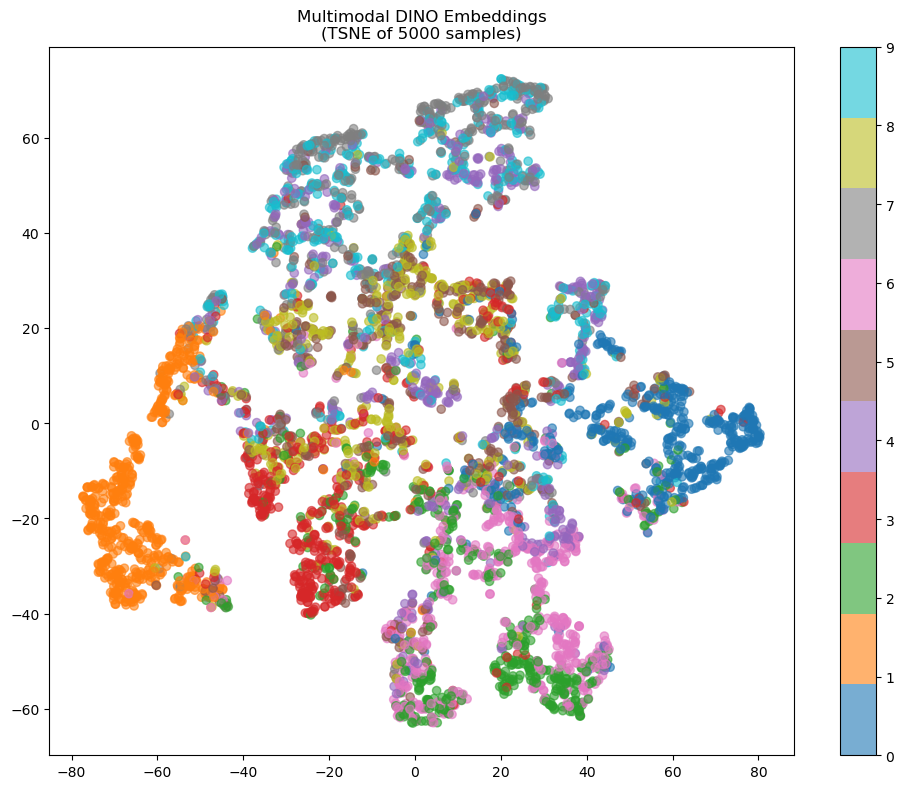

In [40]:
avmnist_data = AVMNISTDataModule(
    data_dir=f'{current_path}/data/avmnist/', 
    num_workers=0, 
    batch_size=128,
    type="burst_noise",
)
avmnist_data.setup()
traindata, validdata, testdata = avmnist_data.train_dataloader(), avmnist_data.val_dataloader(), avmnist_data.test_dataloader() # Load your model

module = MultiModalDINOLightning.load_from_checkpoint(
    best_model_path2, 
    data_dir="data/avmnist/",
    encoder_class=CentralMultiModalEncoder
)
pretrained_dino = module.model

# Run analysis
results = analyze_multimodal_dino(pretrained_dino, validdata)

# Access specific results:
# - results['embeddings']  # Raw embeddings for downstream tasks
# - results['student_projs']  # Student projections
# - results['teacher_projs']  # Teacher projections
# - results['labels']  # Corresponding labels


Concatenated shapes:
embeddings: torch.Size([5000, 128])
student_global_projs: torch.Size([10000, 128])
student_local_projs: torch.Size([20000, 128])
teacher_projs: torch.Size([10000, 128])
labels: torch.Size([5000])

=== Multimodal DINO Analysis ===
Embedding dim: 128
Projection dim: 128
EMA Update Quality:
- Average relative param difference: 0.001891
- Layerwise differences:
  fusion.2.bias: 0.0147
  audio_encoder.transformer.layers.2.self_attn.in_proj_bias: 0.0112
  audio_encoder.transformer.layers.1.self_attn.in_proj_bias: 0.0067
  audio_encoder.transformer.layers.3.self_attn.in_proj_bias: 0.0063
  audio_encoder.transformer.layers.1.self_attn.out_proj.bias: 0.0062

Student Global Projections:
Average Projection Entropy: 1.2420 (max possible: 4.8520)

Student Local Projections:
Average Projection Entropy: 1.2420 (max possible: 4.8520)

Teacher Projections:
Average Projection Entropy: 1.8521 (max possible: 4.8520)
KL Divergence (temp=0.1): 0.0215 (computed on 10000 samples)


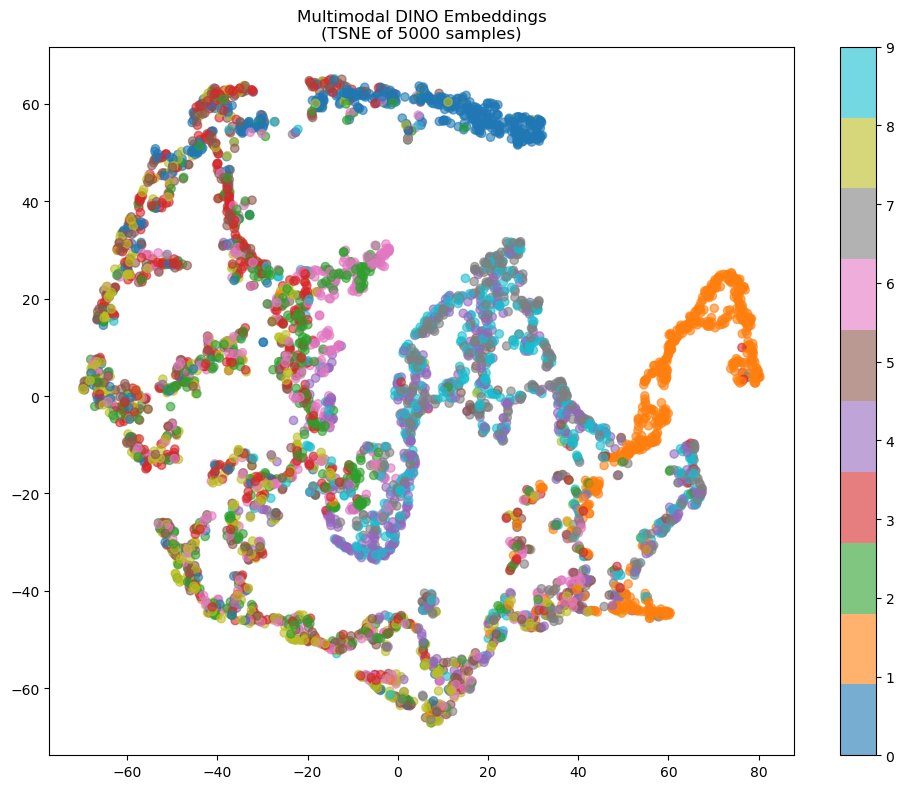

In [41]:
avmnist_data = AVMNISTDataModule(
    data_dir=f'{current_path}/data/avmnist/', 
    num_workers=0, 
    batch_size=128,
    type="burst_noise",
)
avmnist_data.setup()
traindata, validdata, testdata = avmnist_data.train_dataloader(), avmnist_data.val_dataloader(), avmnist_data.test_dataloader() # Load your model

module = MultiModalDINOLightning.load_from_checkpoint(
    best_model_path1, 
    data_dir="data/avmnist/",
    encoder_class=DualViTMultiModalEncoder
)
pretrained_dino = module.model

# Run analysis
results = analyze_multimodal_dino(pretrained_dino, validdata)

# Access specific results:
# - results['embeddings']  # Raw embeddings for downstream tasks
# - results['student_projs']  # Student projections
# - results['teacher_projs']  # Teacher projections
# - results['labels']  # Corresponding labels